In [1]:
# Initial setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
pd.options.display.max_columns = None
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
# Read data info a data frame and preview data structure
lend = pd.read_csv('data/lending_clean.csv')
display(lend.head())
lend.shape

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.00,Jan-2015,171.62,May-2019,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,10.0,29.0,0.837,1
1,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.00,122.9,1.11,Apr-2013,119.66,Oct-2016,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,0.0,15.0,0.094,0
2,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,NaN,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.00,Jun-2014,649.91,Jun-2017,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,10.0,13.0,0.985,1
3,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21%,37.0,f,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,10.0,18.0,2.100,1
4,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9%,38.0,f,0.0,0.0,4066.908161,4066.91,3000.00,1066.91,0.00,0.0,0.00,Jan-2017,67.30,Apr-2018,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,1.0,18.0,0.539,1


(95902, 92)

**Reminder**: target 0 = default, target 1 = paid off

### Time Sensitivity Review
- Would the loan paid off rate fluctuate over time?

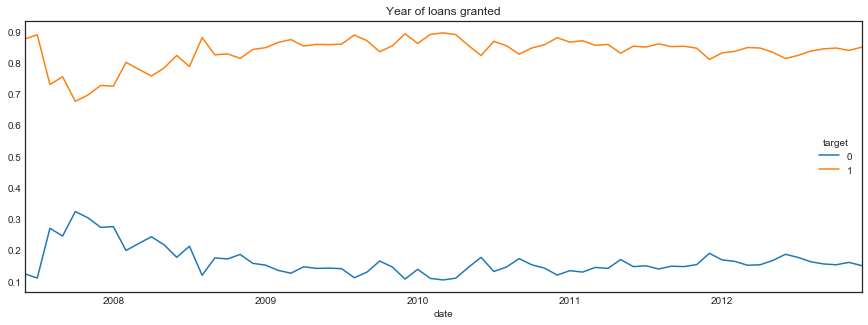

In [3]:
loan_start = lend.groupby(['loan_start_d', 'target'])[['target']].count().unstack(level=1)
loan_start = loan_start.apply(lambda r:r/r.sum(), axis=1)
loan_start['date'] = pd.to_datetime(loan_start.index)
loan_start.plot(x='date', y='target', kind='line', figsize =(15, 5), title='Year of loans granted');

**Findings**: Loan issued during 2008 and prior had higher default rate, probably due to financial crisis. One cannot predict when the next financial crisis will happen, hence data within 2007 and 2008 are outliers for the dataset and would be removed from the analysis

In [4]:
# creating new dataframe by including data post 2019/1/1
lend_2009on = lend[lend['loan_start_d'] >= '2009-1-1']

### Clients Demographic
- Who is borrowing through Lending Club?

In [5]:
lend_2009on['emp_title'].value_counts().head(20)

US Army                    330
Bank of America            235
AT&T                       164
Kaiser Permanente          158
USAF                       141
UPS                        134
Wells Fargo                117
Walmart                    116
USPS                       116
United States Air Force    110
Department of Defense      106
IBM                        106
Lockheed Martin             92
US Air Force                89
State of California         85
US Navy                     85
U.S. Army                   84
JPMorgan Chase              83
walmart                     82
US ARMY                     81
Name: emp_title, dtype: int64

**Findings**: A lot of the applicants work in the military (US Army, Air Force, and Navy). The second category appears to be banks (Bank of America, Wells Fargo, JPMorgan)

### Visualizations

- To simplify the repetition steps for creating visualization, the function below is created.
- The function calculates the % of loans that were paid off (target = 1) within a particular feature (x).

In [6]:
def visual_data(x):
    y = lend_2009on.groupby([x,'target'])[['target']].count().unstack(level=1)
    z = y.apply(lambda r: r/r.sum(), axis=1)
    return z

#### The following attributes will be assessed:
- Employment length
- Property ownership
- Loan purpose
- Credit line history
- Debt to income ratio (DTI)
- Credit utilization rate
- State of the applicants

#### Employment length

          target          
target         0         1
yr_emp                    
0.0     0.152972  0.847028
1.0     0.146910  0.853090
2.0     0.145099  0.854901
3.0     0.151967  0.848033
4.0     0.148366  0.851634
5.0     0.150340  0.849660
6.0     0.158446  0.841554
7.0     0.168372  0.831628
8.0     0.157362  0.842638
9.0     0.152195  0.847805
10.0    0.159604  0.840396


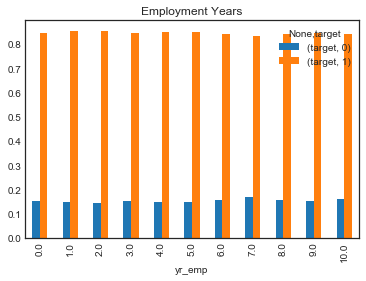

In [7]:
emp_data = visual_data('yr_emp')
emp_data.plot(kind='bar', title='Employment Years');
print(emp_data)

**Findings**: Employment time does not show obvious correlation with| loan pay off rate

#### Property Ownership

                  target          
target                 0         1
home_ownership                    
MORTGAGE        0.144285  0.855715
NONE            0.166667  0.833333
OTHER           0.232143  0.767857
OWN             0.162857  0.837143
RENT            0.166455  0.833545


MORTGAGE    41418
RENT        40990
OWN          7043
OTHER          56
NONE           42
Name: home_ownership, dtype: int64

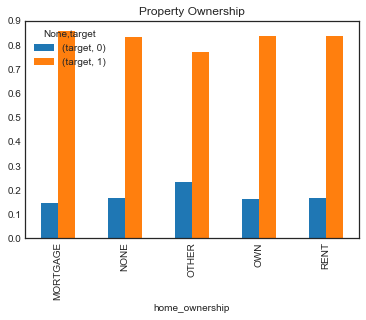

In [8]:
ownership = visual_data('home_ownership')
ownership.plot(kind='bar', title='Property Ownership');
print(ownership)
lend_2009on['home_ownership'].value_counts()

- Owning a mortgage has ~2% high paid off rate. We cannot determine whether 2% is significant at this time. We will access this feature more in inference statistics later. Furthermore, 'NONE', 'OTHER', 'OWN' tend to have lower records and overall lower lower paid off rate. We will combine them into one during machine learning phrase to reduce the number of features that behaves similarly.

#### Loan Purpose

                      target          
target                     0         1
purpose                               
car                 0.102431  0.897569
credit_card         0.121711  0.878289
debt_consolidation  0.166476  0.833524
educational         0.201258  0.798742
home_improvement    0.126591  0.873409
house               0.182415  0.817585
major_purchase      0.110560  0.889440
medical             0.165473  0.834527
moving              0.167382  0.832618
other               0.175749  0.824251
renewable_energy    0.216374  0.783626
small_business      0.264937  0.735063
vacation            0.163352  0.836648
wedding             0.113884  0.886116


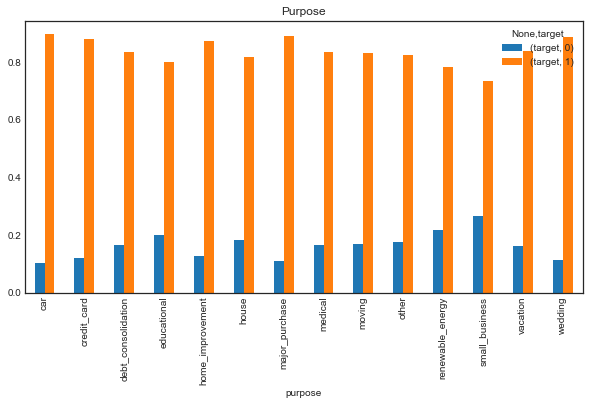

In [9]:
loan_purpose = visual_data('purpose')
loan_purpose.plot(kind='bar', figsize=(10,5), title='Purpose');
print(loan_purpose)

- Default rate varies by purpose. Among those, educational and small_business seem to have highest charge off rate, versus wedding has the lowest.

In [10]:
# Apply the function to the rest of the potential features
yr_credit_g = visual_data('yr_credit')
dti_g = visual_data('dti')
revutil = visual_data('revol_util_dec')
cred_acc = visual_data('total_acc')
state = visual_data('addr_state')

#### Credit History in years

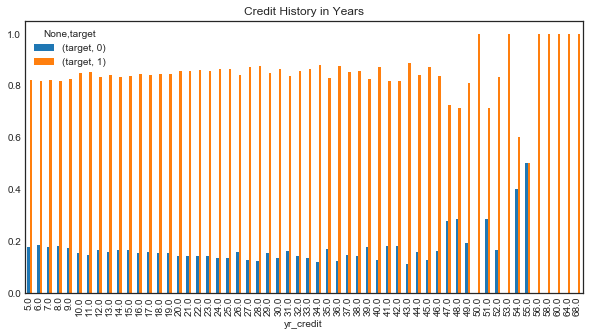

In [11]:
yr_credit_g.plot(kind='bar', figsize=(10,5), title='Credit History in Years');

 - Charge off rate go up from 0-5yrs, then gradually drop toward 10yrs. Post that the default rate stay roughly the same till 30 yrs plus, and that could be driven by outliers due to small sample size.
 
 Double check on the records which has more than 50 years of credit history to ensure its validity.

In [12]:
lend_2009on[lend_2009on.yr_credit > 50]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
1580,21000.0,21000.0,20875.000000,36 months,7.51%,653.33,A,A3,NaN,NaN,MORTGAGE,49200.0,Verified,Dec-2011,Fully Paid,n,NaN,credit_card,Happiness is,591xx,MT,27.02,0.0,1962-09-01,1.0,8.0,0.0,14491.0,19.7%,15.0,f,0.0,0.0,23047.246205,22910.06,21000.00,2047.25,0.0,0.00,0.0000,Sep-2013,10000.95,Sep-2013,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-12-01,NaN,52.0,0.1970,1
3989,5000.0,5000.0,5000.000000,36 months,6.03%,152.18,A,A1,NaN,NaN,OWN,25000.0,Verified,Nov-2011,Fully Paid,n,NaN,debt_consolidation,Debt Consolidation Loan,956xx,CA,29.86,0.0,1963-12-01,0.0,12.0,0.0,22141.0,14.4%,27.0,f,0.0,0.0,5478.387981,5478.39,5000.00,478.39,0.0,0.00,0.0000,Nov-2014,154.50,Nov-2014,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-11-01,NaN,51.0,0.1440,1
4492,6000.0,6000.0,6000.000000,36 months,6.03%,182.62,A,A1,BASF Corporation,10+ years,MORTGAGE,96000.0,Not Verified,Oct-2011,Fully Paid,n,NaN,car,plymouth coupe,776xx,TX,23.80,0.0,1963-03-01,0.0,11.0,0.0,13726.0,32%,27.0,f,0.0,0.0,6493.047509,6493.05,6000.00,493.05,0.0,0.00,0.0000,Oct-2013,2476.98,Jun-2017,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-10-01,10.0,51.0,3.2000,1
6137,4800.0,4800.0,4800.000000,36 months,6.03%,146.10,A,A1,NaN,NaN,RENT,20400.0,Verified,Oct-2011,Fully Paid,n,Borrower added on 10/04/11 > I am a reliable...,debt_consolidation,Debt Consolidation Loan,769xx,TX,19.24,0.0,1954-10-01,0.0,10.0,0.0,10324.0,27.6%,21.0,f,0.0,0.0,5259.228314,5259.23,4800.00,459.23,0.0,0.00,0.0000,Oct-2014,147.48,Oct-2014,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-10-01,NaN,60.0,0.2760,1
7893,12000.0,12000.0,12000.000000,60 months,10.59%,258.47,B,B2,NaN,NaN,OWN,42000.0,Verified,Sep-2011,Charged Off,n,Borrower added on 09/07/11 > We are ready to...,home_improvement,Home Improvement,917xx,CA,0.00,0.0,1962-09-01,0.0,4.0,0.0,0.0,0%,11.0,f,0.0,0.0,9304.920000,9304.92,6382.55,2847.93,0.0,74.44,0.0000,Sep-2014,258.47,Oct-2016,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-09-01,NaN,52.0,0.0000,0
8806,7500.0,7500.0,7500.000000,36 months,5.42%,226.20,A,A1,NaN,NaN,OW

Confirm that records are valid. These applicants have their earliest credit lines back in the 1950s

#### DTI (Debt to Income ratio)

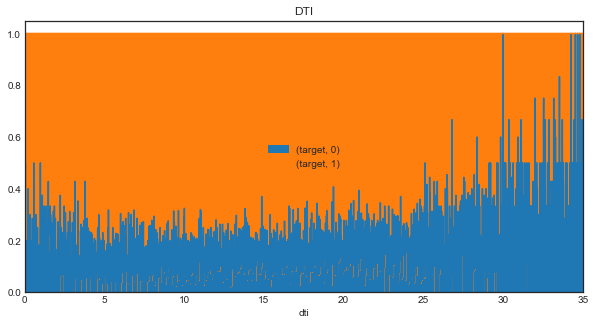

In [13]:
dti_g.plot(kind='area', figsize=(10,5), title='DTI');
plt.legend(loc='center')

 - DTI seems to have positive correlation to loan default starting DTI > 10

#### Credit usage

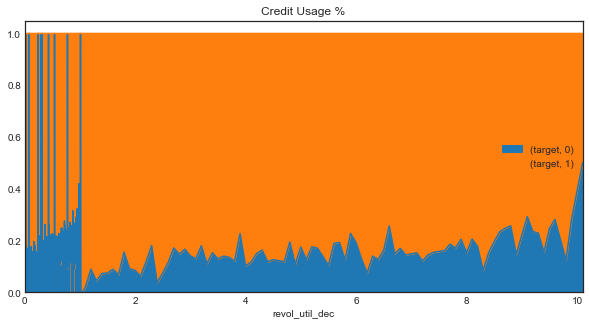

In [14]:
revutil.plot(kind='area', figsize=(10,5), title='Credit Usage %');
plt.legend(loc='best')

- No obvious correlation is observed

#### Number of credit lines

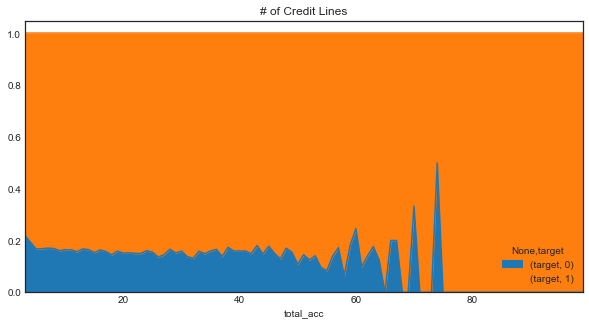

In [15]:
cred_acc.plot(kind='area', figsize=(10,5), title='# of Credit Lines');

- Number of credit line is slightly inversely correlated to default rates

#### Applicant's state

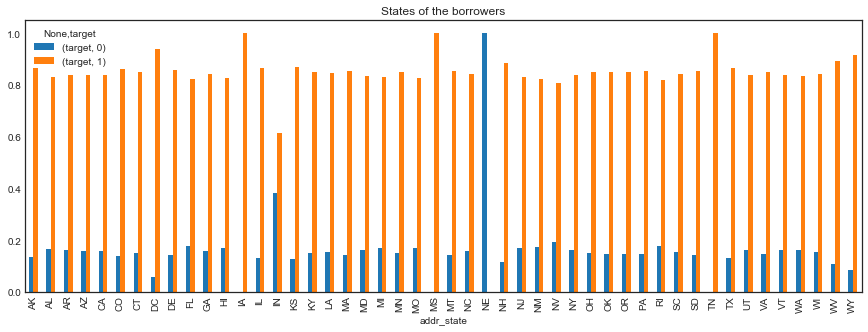

In [16]:
state.plot(kind='bar', figsize=(15,5), title='States of the borrowers');

- States location seem to impact the loan paid off rate

Some states have almost 100% paid off rate, which looks suspicious. We will take a quick look to those records

In [17]:
lend_2009on[(lend_2009on['addr_state'] == 'NE') | (lend_2009on['addr_state'] == 'IA') | (lend_2009on['addr_state'] == 'MS')]

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,loan_start_d,yr_emp,yr_credit,revol_util_dec,target
4760,6000.0,6000.0,6000.0,36 months,15.27%,208.79,C,C4,Mississippi State University,10+ years,OWN,106870.0,Source Verified,Oct-2011,Fully Paid,n,NaN,credit_card,Help loan,397xx,MS,15.99,0.0,1984-05-01,1.0,11.0,0.0,20782.0,66%,35.0,f,0.0,0.0,6364.681189,6364.68,6000.0,364.68,0.0,0.0,0.000,Apr-2012,5533.30,Jun-2019,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2011-10-01,10.0,30.0,6.600,1
29843,9600.0,9600.0,9600.0,36 months,7.14%,297.04,A,A3,Prairie State Legal Services,6 years,MORTGAGE,51996.0,Not Verified,May-2010,Fully Paid,n,Borrower added on 05/19/10 > For what it is ...,debt_consolidation,Great Credit looking to consolidate,527xx,IA,24.60,0.0,1998-10-01,1.0,18.0,0.0,8179.0,16.9%,28.0,f,0.0,0.0,10709.316559,10709.32,9600.0,1094.32,15.0,0.0,0.000,Jun-2013,320.33,May-2013,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2010-05-01,6.0,16.0,0.169,1
49068,21250.0,21250.0,21250.0,60 months,19.05%,551.83,D,D4,NaN,NaN,MORTGAGE,48000.0,Verified,Nov-2012,Charged Off,n,Borrower added on 11/20/12 > For consolidati...,debt_consolidation,Debt consolidation,680xx,NE,31.65,0.0,1995-11-01,1.0,12.0,0.0,8702.0,70.2%,28.0,f,0.0,0.0,19314.050000,19314.05,9923.2,9360.05,0.0,30.8,5.544,Nov-2015,551.83,Feb-2017,0.0,1.0,Individual,0.0,0.0,158004.0,12400.0,2.0,15800.0,798.0,90.1,0.0,0.0,207.0,153.0,29.0,10.0,4.0,78.0,1.0,0.0,1.0,2.0,3.0,7.0,8.0,8.0,16.0,2.0,12.0,0.0,0.0,0.0,2.0,100.0,50.0,0.0,0.0,148912.0,89172.0,8100.0,66822.0,N,N,2012-11-01,NaN,19.0,0.702,0
92623,4000.0,4000.0,4000.0,36 months,10.65%,130.30,B,B2,NaN,5 years,RENT,37000.0,Not Verified,Feb-2012,Fully Paid,n,Borrower added on 01/25/12 > Working hard to...,debt_consolidation,Debt Down!!!,392xx,MS,24.42,0.0,2001-09-01,1.0,12.0,0.0,12019.0,91.1%,24.0,f,0.0,0.0,4690.500000,4690.50,4000.0,690.50,0.0,0.0,0.000,Feb-2015,141.23,Jan-2018,0.0,1.0,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,2012-02-01,5.0,13.0,0.911,1


There are limited records for IA and NE, which have 100% paid off rate. Hence, the high paid off rate is no statically significant. This also suggest that other states which have high paid off rates could be skewed by small records number. We will keep this in mind when we are creating feature variable for this.

### Conclusion:

- Loan Purposes has noticeable impact on the loan repayment rate. Loans to fund new businesses have the highest default rate. Loans for major life events such as wedding and major purchases have lower chance of default.
- Observed difference in paid off rates among state. However, that may subject to number of records by state and will need further investigations.
- Years of credit history, DTI, number of credit lines, property ownership indicate some correlation to loan default rates, and will need further analysis
- Employment history and Credit usage do not indicates relationship to the loan paid off rates. We will not adopt this feature in the machine learning portion.

Save a copy of the condensed dataset with selected features to save time for data manipulation in the inference statistics and machine learning sections.

Features that are selected are home ownership status, loan purpose, years of credit, Debt to Income ratio, number of credit lines, and applicant's state 

In [18]:
lend_ml = lend_2009on[['home_ownership','purpose', 'yr_credit', 'dti', 'total_acc', 'addr_state', 'target']]
lend_ml.to_csv('data/lending_ml.csv', index=False)

[Back to README](https://github.com/sittingman/lending_repayment)